### In this notebook, we explore the electronic band structure of the kagome tight-binding model in the nearest-neighbor limit.

We investigate two main scenarios: 
1. $\mathcal{C}_6$ is explicitly-broken 
2. $\mathcal{C}_6$ is preserved





In [4]:
using LinearAlgebra
using Makie 
using CairoMakie 
using Brillouin
using Printf
using PlotlyJS
using Symbolics
using StaticArrays

--- Plotting the Wigner-Seitz cell in real space. 

--- Vertices of the real Wigner-Seitz cell (in reduced coordinates): 
  0.666667   0.333333 
  0.333333  -0.333333 
 -0.333333  -0.666667 
 -0.666667  -0.333333 
 -0.333333   0.333333 
  0.333333   0.666667 

--- Plotting the Wigner-Seitz cell in reciprocal space. 

--- Vertices of the reciprocal space Wigner-Seitz cell (in reduced coordinates): 
 -0.666667   0.333333 
 -0.333333   0.666667 
  0.333333   0.333333 
  0.666667  -0.333333 
  0.333333  -0.666667 
 -0.333333  -0.333333 

--- Vertices of the reciprocal space Wigner-Seitz cell (in cartesian coordinates): 
  2.094395   3.627599 
  4.188790  -0.000000 
  2.094395  -3.627599 
 -2.094395  -3.627599 
 -4.188790   0.000000 
 -2.094395   3.627599 



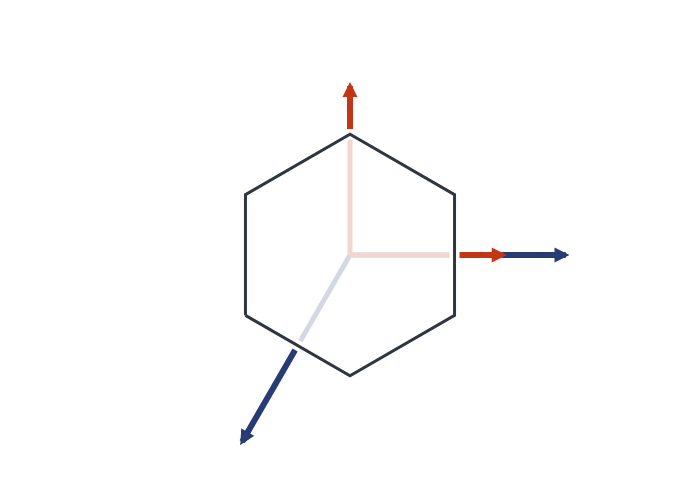

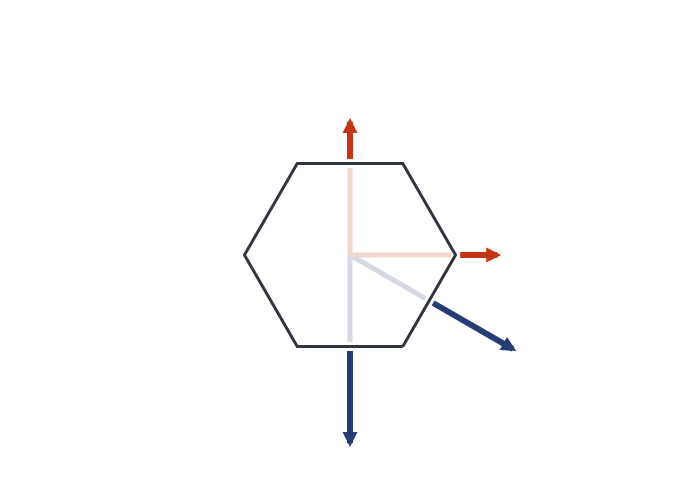

In [5]:
# Useful C_3 rotation
global const C_3::Matrix{Float64} = [cos(2.0*pi/3.0) -sin(2.0*pi/3.0); sin(2.0*pi/3.0) cos(2.0*pi/3.0)]

# Useful C_6 rotation
global const C_6::Matrix{Float64} = [cos(pi/3.0) -sin(pi/3.0); sin(pi/3.0) cos(pi/3.0)]


# Reciprocal and Direct Lattice   R1 and R2 are the basis vectors in the real space ! 
global const R1::Vector{Float64} = [-0.5, -0.5 * sqrt(3.0)]
global const R2::Vector{Float64} = C_3 * R1
global const R3::Vector{Float64} = C_3 * R2;

# Now, the reciprocal lattice 
global const R::Matrix{Float64} = [R1 R2]';
global const G::Matrix{Float64} = 2.0 * pi * inv(R');

let
    print("--- Plotting the Wigner-Seitz cell in real space. \n")
    print("\n")

    As = [R[i, :] for i ∈ 1 : size(R, 1)]
    real_wignerseitz = wignerseitz(As)

    vertices = real_wignerseitz.verts

    print("--- Vertices of the real Wigner-Seitz cell (in reduced coordinates): \n")
    for v ∈ vertices
        @printf("%10f %10f \n", v[1], v[2])
    end
    print("\n")

    pbzb = PlotlyJS.plot(real_wignerseitz)
    display(pbzb)

end

let
    print("--- Plotting the Wigner-Seitz cell in reciprocal space. \n")
    print("\n")

    G1 = G[1, :]; G2 = G[2, :]
    Gs = [G[i, :] for i ∈ 1 : size(G, 1)]
    recip_wignerseitz = wignerseitz(Gs)

    vertices = recip_wignerseitz.verts

    # Here, we want the cartesian coordinates of the corners (vertices of the FBZ). We also need the cartesian coordinates of the M point 
    global cart_v::Vector{Vector{Float64}} = similar(vertices)
    for i ∈ 1:size(cart_v, 1)
        red_v = vertices[i]
        cart_v[i] = red_v[1] * G1 + red_v[2] * G2
    end

    print("--- Vertices of the reciprocal space Wigner-Seitz cell (in reduced coordinates): \n")
    for v ∈ vertices
        @printf("%10f %10f \n", v[1], v[2])
    end
    print("\n")

    print("--- Vertices of the reciprocal space Wigner-Seitz cell (in cartesian coordinates): \n")
    for v ∈ cart_v
        @printf("%10f %10f \n", v[1], v[2])
    end
    print("\n")

    pbzb = PlotlyJS.plot(recip_wignerseitz)
    display(pbzb)

end

In [6]:
global const cK::SVector{2, Float64} = SVector{2, Float64}(cart_v[2])
global const cK_I::SVector{2, Float64} = @SVector [2.094395, 3.627599]
# Now, the K-Points 
global const high_symmetry_points = Dict{String, SVector{2, Float64}}(
    "K"=> cK, 
    "M"=> (cK + cK_I) / 2.0,
    "Γ"=> [0.0, 0.0] 
)


Dict{String, SVector{2, Float64}} with 3 entries:
  "M" => [3.14159, 1.8138]
  "Γ" => [0.0, 0.0]
  "K" => [4.18879, -8.88178e-16]

In [7]:
struct Params

    # we will use unicode characters to name the variables 

    # Parameters for the upright triangle 
    t1Δ::Float64
    t2Δ::Float64
    t3Δ::Float64
    # Parameters for the inverted triangle 
    t1∇::Float64
    t2∇::Float64
    t3∇::Float64
    

end


In [40]:
global const T1u  = @SArray ComplexF64[0.0 1.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
global const T2u  = @SArray ComplexF64[0.0 0.0 1.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
global const T3u  = @SArray ComplexF64[0.0 0.0 0.0; 0.0 0.0 1.0; 0.0 0.0 0.0];

# Implement the Hamiltonian in Nagosa's paper without spin-orbit interaction or magnetism 
@inline function HamBreathingKagomeNoSOC(k::Vector{Float64}, p::Params)
    kx::Float64 = k[1]; ky::Float64 = k[2] 
    Ham::SMatrix{3, 3, ComplexF64} = -SMatrix{3, 3, ComplexF64}((p.t1Δ + p.t1∇ * exp(im * (0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T1u + (p.t2Δ + p.t2∇ * exp(-im * kx)) * T3u + 
    (p.t3Δ + p.t3∇ * exp(im * (-0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T2u)
    Hermitian(Ham + Ham')
end

@inline function HamBreathingKagomeNoSOC(k::SVector{2, Float64}, p::Params)
    kx::Float64 = k[1]; ky::Float64 = k[2] 
    Ham::SMatrix{3, 3, ComplexF64} = -SMatrix{3, 3, ComplexF64}((p.t1Δ + p.t1∇ * exp(im * (0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T1u + (p.t2Δ + p.t2∇ * exp(-im * kx)) * T3u + 
    (p.t3Δ + p.t3∇ * exp(im * (-0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T2u)
    Hermitian(Ham + Ham')
end


@inline function EvalsHamBreathingKagomeNoSOC(k::SVector{2, Float64}, p::Params)
    kx::Float64 = k[1]; ky::Float64 = k[2] 
    Ham::SMatrix{3, 3, ComplexF64} = -SMatrix{3, 3, ComplexF64}((p.t1Δ + p.t1∇ * exp(im * (0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T1u + (p.t2Δ + p.t2∇ * exp(-im * kx)) * T3u + 
    (p.t3Δ + p.t3∇ * exp(im * (-0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T2u)
    eigvals(Hermitian(Ham + Ham'))
end

@inline function EvalsHamBreathingKagomeNoSOC(k::Vector{Float64}, p::Params)
    kx::Float64 = k[1]; ky::Float64 = k[2] 
    Ham::SMatrix{3, 3, ComplexF64} = -SMatrix{3, 3, ComplexF64}((p.t1Δ + p.t1∇ * exp(im * (0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T1u + (p.t2Δ + p.t2∇ * exp(-im * kx)) * T3u + 
    (p.t3Δ + p.t3∇ * exp(im * (-0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T2u)
    eigvals(Hermitian(Ham + Ham'))
end

@inline function EigensystemHamBreathingKagomeNoSOC(k::Vector{Float64}, p::Params)
    kx::Float64 = k[1]; ky::Float64 = k[2] 
    Ham::SMatrix{3, 3, ComplexF64} = -SMatrix{3, 3, ComplexF64}((p.t1Δ + p.t1∇ * exp(im * (0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T1u + (p.t2Δ + p.t2∇ * exp(-im * kx)) * T3u + 
    (p.t3Δ + p.t3∇ * exp(im * (-0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T2u)
    eigen(Hermitian(Ham + Ham'))
end


EigensystemHamBreathingKagomeNoSOC (generic function with 1 method)

Now, we plot the band structure in four cases. Let label the four models: $m_{111}$, $m^{b}_{111}$, $m_{122}$, and $m_{123}$. 
1. $m_{111}$: Here we choose $t^{\Delta / \nabla}_{i} = t$. This model possesses $\mathcal{C}_6$ symmetry


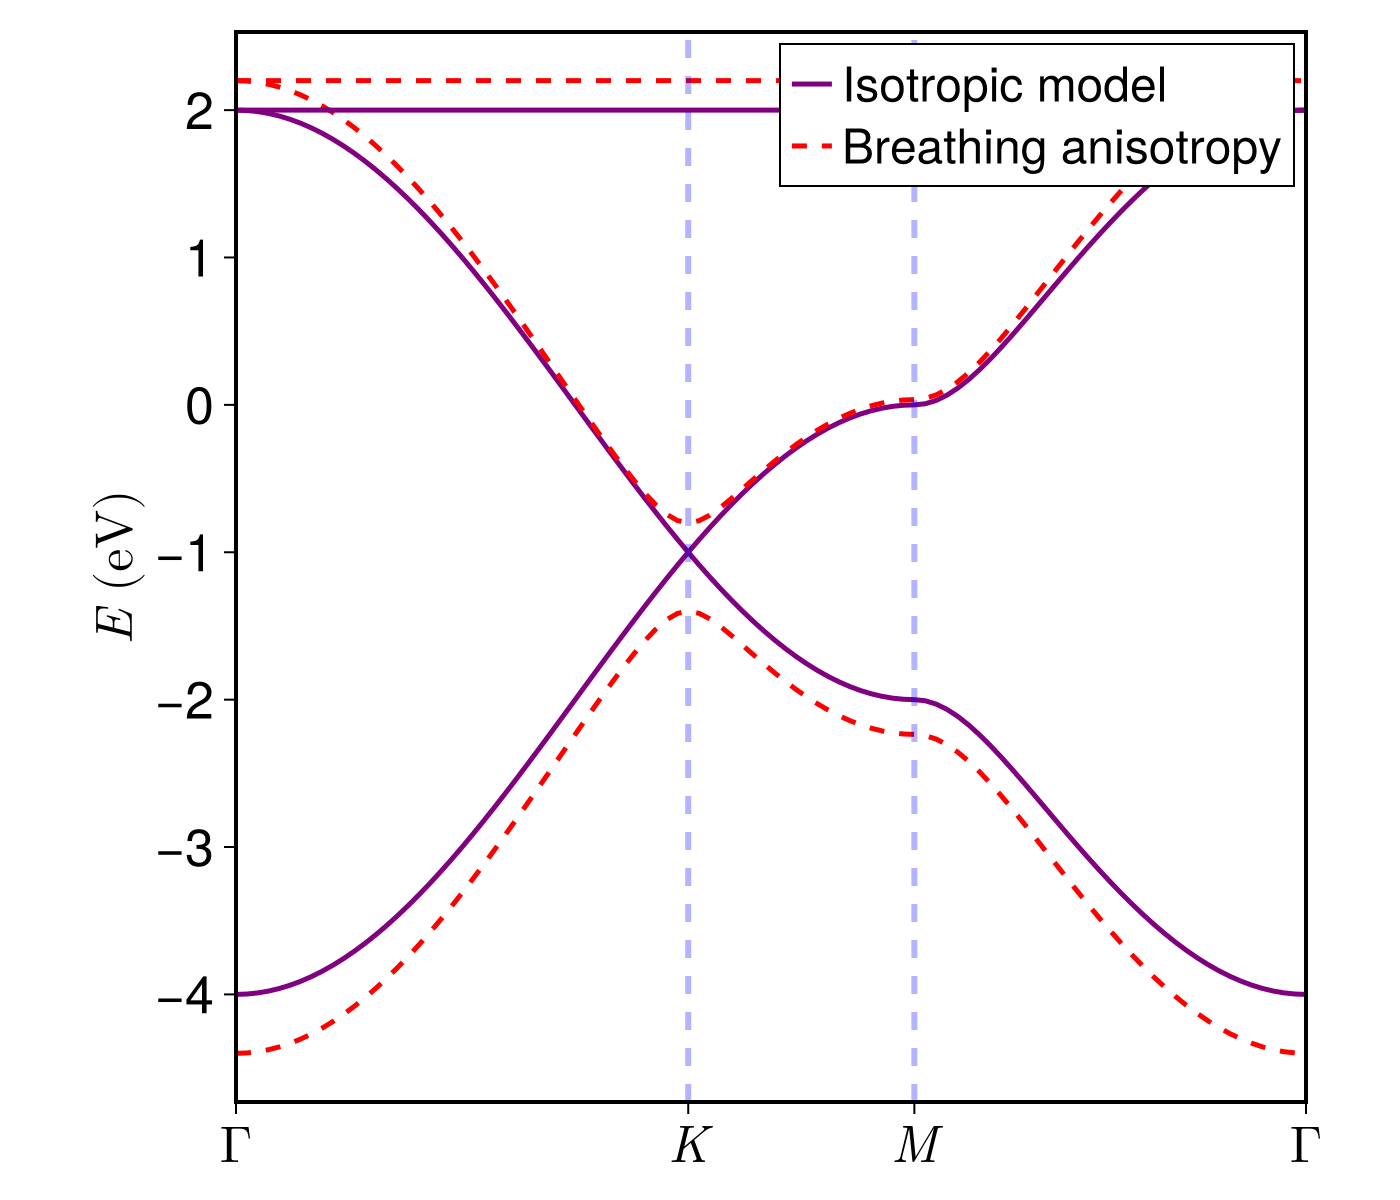

In [51]:
let t_m111::Float64 = 1.0, 
        tb_m111_Δ::Float64 = 1.2, 
        tb_m11_∇::Float64 = 1.0


    p_m111  = Params(t_m111, t_m111, t_m111, t_m111, t_m111, t_m111)
    p_mb111 = Params(tb_m111_Δ, tb_m111_Δ, tb_m111_Δ, tb_m11_∇, tb_m11_∇, tb_m11_∇)

    nps::Int64 = 100 

    # k points 
    k_nodes::Vector{SVector{2, Float64}} = [high_symmetry_points["Γ"], 
                    high_symmetry_points["K"], 
                    high_symmetry_points["M"], 
                    high_symmetry_points["Γ"]];
    kps::Vector{Vector{Float64}} = interpolate(k_nodes, nps);
    kps = [SVector{2, Float64}(v) for v ∈ kps]

    # calculation of the x values needed to construct the band structure 
    xs = Vector{Float64}(undef, nps)
    xs[1] = 0.0 
    ϵ::Float64 = 0.0 
    for ik ∈ 2 : nps
        ϵ += norm(kps[ik, :] - kps[ik - 1, :])
        xs[ik] = ϵ
    end

    tick_labels = [L"\Gamma", L"K", L"M", L"\Gamma"]


    eks_m111 = EvalsHamBreathingKagomeNoSOC.(kps, Ref(p_m111)); 
    eks_mb111 = EvalsHamBreathingKagomeNoSOC.(kps, Ref(p_mb111)); 
    K = high_symmetry_points["K"]; M = high_symmetry_points["M"]
    Kpos        = norm(K); Mpos = norm(K) + norm(M - K);
    tick_pos    = [0.0, Kpos, Mpos, xs[end]]

    # Now, main plotting code 
    aspect_ratio = 1.0
    f = Figure(size = (700, 600))
    ax = Axis(f[1, 1],
        aspect = aspect_ratio,
        ylabel = L"E \ (\text{eV})",
        yticklabelsize = 26.0,
        xticklabelsize = 26.0,
        ylabelsize = 26,
        xlabelsize = 26,
        spinewidth = 2,
        limits = (xs[1], xs[end], nothing, nothing),
        )
    ax.xticks = (tick_pos, tick_labels)


    # Line Plots 
    for i ∈ 1 : 3 
        lines!(ax, xs, map(x -> x[i], eks_m111), color = :purple, linewidth = 2.5, label = "Isotropic model")
        lines!(ax, xs, map(x -> x[i], eks_mb111), color = :red, linewidth = 2.5, linestyle = :dash, label = "Breathing anisotropy")
    end

    hideydecorations!(ax, grid = true, label = false, ticks = false, ticklabels = false)
    hidexdecorations!(ax, grid = true, ticks = false, ticklabels = false)
    vlines!(ax, [Kpos, Mpos], color = (0, 0, 1, 0.3), linewidth = 3, linestyle = :dash)

    # create legends 
    axislegend(ax, merge = true, unique = true, labelsize = 24)
    save("bands_weak_breathing_anisotropy.png", f)
    f

end